# EEC2006 - Data Science
# Project - Gender classification of UFRN

## Victor Hugo - 20171003230

## 1. Introduction 

The main goal of this notebook is to identify the percentage of men and women of the employees of the Universidade Federal do Rio Grande do Norte (UFRN), which is classified as a IES. However, there is no dataset avalaible with those informations, but there is a webpage, [Portal da Transparência](http://www.portaldatransparencia.gov.br/), that list all the government spendings, including the list of all his employees. Therefore, once the UFRN is a public college, their workers is listed in this webpage.

This leads us to the need of doing web scrap to get the informations that we want. But this doesn't solve our problem, because there is no gender information on the Portal da Transparência. Therefore, we will use some APIs to classify the gender of each employee.

In the next section we will show how our dataset was build and what informations was collected. In the section 3 we discuss the gender classification. And in section 4 we show some insights of our data.

## 2. Employees dataset

We used the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) and [requests](http://docs.python-requests.org/en/master/) for the web scraping. There is a plenty of documention on the Internet about those two libraries.

To be a litle more general, our script takes a list of all the wanted IES's to be scraped. For doing so, we start in the webpage that list all the IES's and iterate all over it looking for the ones listed. For each IES found, we iterate over all their employees and for each employee we collect some basic informations, including their paychecks.

Bellow, we show the script use it to collect all the information. In our case, we only listed the UFRN, mostly because the time it took to collect all those informations.


In [1]:
# import packages
from requests import get
from bs4 import BeautifulSoup

from time import sleep
from random import randint
from time import time
from datetime import date
from warnings import warn

import csv
import pandas as pd
import numpy as np
import json
import datetime as dt


In [2]:
# initial url of all the IES of the ministry of education
url = 'http://www.portaldatransparencia.gov.br/servidores/\
OrgaoExercicio-ListaOrgaos.asp?CodOS=15000'

# packages the request, send the request and catch the response
response = get(url)

# get the html parser
html_soup = BeautifulSoup(response.text, 'html.parser')

# get the number of pages of the list
number_pages = html_soup.find_all('p', class_ = 'paginaAtual')
number_pages = number_pages[0].text.split('/')[1]

# make a list of pages to facilitate the iteration
pages = [ str(i) for i in range(1,int(number_pages)+1) ]

In [3]:
# list of all the IES that we want to scrap the informations
list_IES = ['UNIVERSIDADE FED. DO RIO GRANDE DO NORTE']


In [4]:
# make a list of tuples with the past 12 months in the format ('year', 'month')
today = date.today()

last_12_months = []

for i in range(1,13):
    year = today.year
    month = today.month - i - 1
    if month < 1:
        month += 12
        year -= 1
    tuple_ = ( str(year), str(month) )    
    last_12_months.append(tuple_)
   

In [5]:
# initializing our file that will act like our dataset

#open the file in the 'write' mode
file = open('db_notebook.csv','w')
writer = csv.writer(file) 

db_row = ['NAME', 'IES', 'FUNCTION', 'WORKING_HOURS', 'ADMISSION_DATE', 
          'SALARY_1', 'SALARY_2','SALARY_3','SALARY_4','SALARY_5','SALARY_6',
          'SALARY_7', 'SALARY_8','SALARY_9','SALARY_10','SALARY_11','SALARY_12']

#write the row mounted
writer.writerow(db_row)

#close the file
file.close()

In [6]:
debug = False

In [7]:

base_url = 'http://www.portaltransparencia.gov.br/servidores/'

# For each page of the list of all IES
for page in pages:
    
    #url of each page of the list of all IES
    main_url = base_url + 'OrgaoExercicio-ListaOrgaos.asp?CodOS=15000&Pagina={}'.format(page).replace(" ", "")
    if debug:
        print(main_url)
    
    # Make a get request
    main_response = get(main_url)
    # Throw a warning for non-200 status codes
    if main_response.status_code != 200:
        warn('URL: {}; Status code: {}'.format(main_url, main_response.status_code))
    # Pause
    sleep(randint(1,2))
    
    # get the html parser
    html_main = BeautifulSoup(main_response.text, 'html.parser')
        
        
    # information about IES is within a table element
    unit_table = html_main.find_all('table')
    
    # the second one is the target
    unit_rows  = unit_table[1].find_all('tr')
    unit_rows = unit_rows[1:]
    
    # Extract data from individual ies rows
    for row in unit_rows:
        
        # ies names
        ies_name = row.find('a').text
        ies_name = ies_name.strip()
        
        # if ies name is in the list of the wanted IES, extract the informations of it
        if ies_name in list_IES:
            if debug:
                print('%s is in list_IES' % ies_name)
            
            # rh codes
            rh_code = row.find('td', class_ = 'firstChild').text
            rh_code = rh_code.strip()
            
            # url of the list of all employees of the specific ies
            ies_url = base_url + 'OrgaoExercicio-ListaServidores.asp?CodOrg={}'.format(rh_code).replace(" ","")
            if debug:
                print(ies_url)
            
            ies_response = get(ies_url)
            # Throw a warning for non-200 status codes
            if ies_response.status_code != 200:
                warn('URL: {}; Status code: {}'.format(ies_url, ies_response.status_code))
            # Pause the loop
            sleep(randint(1,2))
            
            html_ies = BeautifulSoup(ies_response.text, 'html.parser')
            
            # get the number of pages of the ies
            number_pages_ies = html_ies.find_all('p', class_ = 'paginaAtual')
            number_pages_ies = number_pages_ies[0].text.split('/')[1]
            pages_ies = [ str(i) for i in range(1,int(number_pages_ies)+1) ]
            
            # for each page of the ies, get the following informations of all the employees:
            # - name
            # - function
            # - admission date
            # - working hours
            # - salary for the past 6 months
            for page_ies in pages_ies:
                # url of each page of the ies
                page_ies_url = (base_url + 
                                'OrgaoExercicio-ListaServidores.asp?CodOrg={}&Pagina={}'.
                                format(rh_code, page_ies).replace(" ",""))
                if debug:
                    print(page_ies_url)
                
                page_ies_response = get(page_ies_url)
                # Throw a warning for non-200 status codes
                if page_ies_response.status_code != 200:
                    warn('URL: {}; Status code: {}'.format(page_ies_url, page_ies_response.status_code))                
                # Pause the loop
                sleep(randint(1,2))
                
                page_html_ies = BeautifulSoup(page_ies_response.text, 'html.parser')
                
                # the names are in a 'td' inside the 'div' with the id='listagem'
                # in the div with id equal to 'listagem' there is a list of 'td'
                # in this list there is some 'td' that has a hyperlink, 
                # this are the ones with the names of the employees
                list_ = page_html_ies.find('div', id='listagem')
                names = list_.find_all('td')
                
                
                # for each name ('td') in the list of names ('td')
                for name in names:
                    # find the 'td' that has a hyperlink
                    if name.find('a') is not None:
                        
                        # list that will receive all the data to insert into the .csv file
                        db_row = []
                        
                        if debug:
                            print(name.text)
                            print(name.find('a')['href'])
                        #insert the employee name                        
                        db_row.append(name.text.strip())
                        #insert the ies name
                        db_row.append(ies_name.strip())                        
                        
                        
                        # url of each employee
                        employee_url = (base_url + name.find('a')['href']).replace(" ","")
                        if debug:
                            print(employee_url)
                        
                        employee_response = get(employee_url)
                        # Throw a warning for non-200 status codes
                        if employee_response.status_code != 200:
                            warn('URL: {}; Status code: {}'.format(employee_url, employee_response.status_code))
                        # Pause the loop
                        sleep(randint(1,2))
                        
                        employee_html = BeautifulSoup(employee_response.text, 'html.parser')
                        
                        # the details of each employee is inside of 'td' in a table
                        table_employee = employee_html.find('table', summary='Detalhes do Servidor')
                        rows_employee = table_employee.find_all('td')
                        
                        # initialize the function and working hours variable
                        # in the case of we don't find those values, a blank data will be inserted in the .csv file
                        function_employee = ''
                        working_hours = ''
                        admission_date = ''
                        # look for the 'td' with the information of the function and the working hours
                        for i, row_employee in enumerate(rows_employee):
                            if row_employee.text.strip() == 'Cargo Emprego:':
                                function_employee = rows_employee[i+1].text.strip()
                            
                            if row_employee.text.strip() == 'Jornada de Trabalho:':
                                working_hours = rows_employee[i+1].text.strip()
                            
                            if row_employee.text.strip() == 'Data de publicação:':
                                admission_date = rows_employee[i+1].text.strip()
                        
                        if debug:
                            print(function_employee)
                            print(working_hours)
                            print(admission_date)
                        
                        #insert the employee function
                        db_row.append(function_employee)
                        #insert the employee workings hours
                        db_row.append(working_hours)  
                        #insert the employee admission date
                        db_row.append(admission_date)
                        
                        # get the url that has the salary informations of the employee
                        salary_url = employee_html.find('div', id='resumo')
                        salary_url = salary_url.find('a')['href']
                        salary_url = 'http://www.portaltransparencia.gov.br' + salary_url
                        if debug:
                            print(salary_url)
                            
                        # get the salary of the last 12 months
                        for year_month in last_12_months:
                            # get the url for the salary of each month
                            month_salary_url = (salary_url + 
                                                '&Ano={}&Mes={}'.
                                                format(year_month[0],year_month[1]).
                                                replace(" ",""))
                            
                            if debug:
                                print(month_salary_url)
                            
                            salary_response = get(month_salary_url)
                            # Throw a warning for non-200 status codes
                            if salary_response.status_code != 200:
                                warn('URL: {}; Status code: {}'.format(month_salary_url, salary_response.status_code))
                            # Pause the loop
                            sleep(randint(1,2))
                            
                            salary_html = BeautifulSoup(salary_response.text, 'html.parser')
                            
                            # the net salary can be expressed by the sum of two parts:
                            # 1- 'Total da Remuneração Após Deduções'; and
                            # 2- 'Total de verbas indenizatórias'
                            # both of them is inside a 'tr' with class = 'remuneracaolinhatotalliquida' and
                            # within a 'td' with class = 'colunaValor'
                            net_salary = salary_html.find_all('tr', class_='remuneracaolinhatotalliquida')
                            if len(net_salary) == 2:
                                total_salary_1 = net_salary[0].find('td', class_='colunaValor').text
                                total_salary_2 = net_salary[1].find('td', class_='colunaValor').text
                                
                                total_salary_1 = total_salary_1.replace('.','')
                                total_salary_1 = total_salary_1.replace(',','.')
                                
                                total_salary_2 = total_salary_2.replace('.','')
                                total_salary_2 = total_salary_2.replace(',','.')
                                
                                total_salary = float(total_salary_1) + float(total_salary_2)
                                if debug:
                                    print(total_salary)
                                
                                db_row.append(total_salary)
    
                            else:
                                total_salary = ''
                                if debug:
                                    print(total_salary)
                                
                                db_row.append(total_salary)
                        
                        #print the row in the terminal for the user see whats going on the server
                        print(db_row)
                        
                        #open the file that will act like a database in the 'append' mode
                        #which allow us to append a row each time we open it
                        file = open('db_notebook.csv','a')
                        writer = csv.writer(file)                        
                        #write the row mounted
                        writer.writerow(db_row)
                        
                        #close the file
                        file.close()
                        

['ABDO FARRET NETO', 'UNIVERSIDADE FED. DO RIO GRANDE DO NORTE', 'PROFESSOR DO MAGISTERIO SUPERIOR', '20 HORAS SEMANAIS', '09/02/2009', '', '', '', '', '', '', '', '', '', '', '', '']
['ABMAEL BEZERRA DE OLIVEIRA', 'UNIVERSIDADE FED. DO RIO GRANDE DO NORTE', 'PROFESSOR DO MAGISTERIO SUPERIOR', 'DEDICACAO EXCLUSIVA', '01/03/1973', 9350.92, 9350.92, 9107.7, 9107.7, 9107.7, 9107.7, 9107.7, '', '', '', '', '']


KeyboardInterrupt: 

### 2.1 Created dataset

Bellow we analyze the final database created. Initially, we have the following columns:

- **NAME**: the name of the employee;
- **IES**: the name of the IES, in our case, all the employees are from UFRN;
- **FUNCTION**: the name of the function of the employee in UFRN;
- **WORKING_HOURS**: indicates how many hour per week the employee works. There is also the possibility that the worker has exclusive dedication, which means that, in general, he works 40 hours per week, but he can't have another paid occupation;
- **ADMISSION_DATE**: the date that the employee started to work for UFRN;
- **SALARY_[1_12]**: the values of the past 12 salaries.


In [8]:
# read one final dataset
data = pd.read_csv('db_final.csv')

In [9]:
#show the first 5 rows
data.head()

,NAME,IES,FUNCTION,WORKING_HOURS,ADMISSION_DATE,SALARY_1,SALARY_2,SALARY_3,SALARY_4,SALARY_5,SALARY_6,SALARY_7,SALARY_8,SALARY_9,SALARY_10,SALARY_11,SALARY_12
0,ABDO FARRET NETO,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,20 HORAS SEMANAIS,09/02/2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABMAEL BEZERRA DE OLIVEIRA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,01/03/1973,9350.92,9350.92,9107.70,9107.70,9107.70,9107.70,9107.70,NaN,NaN,NaN,NaN,NaN
2,ABNER CARLOS COSTA DE MELO,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,TECNICO EM ELETROTECNICA,40 HORAS SEMANAIS,23/07/2014,3019.80,2929.01,2929.01,4327.33,2929.01,3861.22,2929.01,NaN,NaN,NaN,NaN,NaN
3,ABRAHAO SANDERSON NUNES FERNANDES DA SILVA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,23/12/2008,9691.23,9691.23,9537.53,15080.28,9537.53,9537.53,9537.53,NaN,NaN,NaN,NaN,NaN
4,ACACIA JESSICA MAIA DE MOURA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,ASSISTENTE SOCIAL,40 HORAS SEMANAIS,19/06/2013,6007.89,6007.89,5800.58,11470.01,5840.69,5840.69,5840.69,NaN,NaN,NaN,NaN,NaN


In [10]:
#show some basic informations
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 17 columns):
NAME              6183 non-null object
IES               6183 non-null object
FUNCTION          4979 non-null object
WORKING_HOURS     6183 non-null object
ADMISSION_DATE    6183 non-null object
SALARY_1          5245 non-null float64
SALARY_2          5258 non-null float64
SALARY_3          5184 non-null float64
SALARY_4          5180 non-null float64
SALARY_5          5130 non-null float64
SALARY_6          5139 non-null float64
SALARY_7          5128 non-null float64
SALARY_8          1 non-null float64
SALARY_9          0 non-null float64
SALARY_10         0 non-null float64
SALARY_11         0 non-null float64
SALARY_12         0 non-null float64
dtypes: float64(12), object(5)
memory usage: 821.3+ KB


### 2.2 Manipulation of the dataset

In order to simplify the operations along this notebook, we did some manipulations in the original dataset, which was:

- Replace the 12 salaries column for one column that has the mean value ('MEAN_SALARY);
- Include one column with only the first name ('FIRST_NAME') and another column with only the last name ('LAST_NAME');
- Include a column that tells the service time (in years) of each employee based on his admission date and today's day.

In [11]:
# calculate mean salary based in all the salary columns
# if all the columns salaries are 'null', then return a NaN
def calculate_mean_salary(row):
    array = []
    
    for i in range(1,13):
        if not pd.isnull( row[ 'SALARY_{}'.format(str(i)) ] ):
            array.append( row[ 'SALARY_{}'.format(str(i)) ] )
    
    if len(array) > 0:
        mean = np.mean( array )
    else:
        mean = np.nan
        
    return mean


mean_salary = data.apply(calculate_mean_salary, axis=1)

data["MEAN_SALARY"] = mean_salary

data.drop(['SALARY_1', 'SALARY_2','SALARY_3','SALARY_4','SALARY_5','SALARY_6',
           'SALARY_7', 'SALARY_8','SALARY_9','SALARY_10','SALARY_11','SALARY_12'],
          axis=1, inplace=True)


In [12]:
def get_first_name(row):
    return row['NAME'].split(' ')[0]

def get_last_name(row):
    return row['NAME'].split(' ')[-1]

first_name = data.apply(get_first_name, axis=1)
last_name = data.apply(get_last_name, axis=1)

data['FIRST_NAME'] = first_name
data['LAST_NAME'] = last_name


In [13]:
# calculate the service time (in years) of each employee, based on today
def get_service_time(row):
    try:
        service_time = date.today() - pd.to_datetime(row['ADMISSION_DATE'], format='%d/%m/%Y').date()
        service_time = service_time.days
        # return the service time in years
        service_time = service_time / 365
    except:
        service_time = np.nan
        
    return service_time

service_time = data.apply(get_service_time,axis=1)
data['SERVICE_TIME'] = service_time

data.head()

,NAME,IES,FUNCTION,WORKING_HOURS,ADMISSION_DATE,MEAN_SALARY,FIRST_NAME,LAST_NAME,SERVICE_TIME
0,ABDO FARRET NETO,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,20 HORAS SEMANAIS,09/02/2009,NaN,ABDO,NETO,8.789041
1,ABMAEL BEZERRA DE OLIVEIRA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,01/03/1973,9177.191429,ABMAEL,OLIVEIRA,44.758904
2,ABNER CARLOS COSTA DE MELO,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,TECNICO EM ELETROTECNICA,40 HORAS SEMANAIS,23/07/2014,3274.912857,ABNER,MELO,3.336986
3,ABRAHAO SANDERSON NUNES FERNANDES DA SILVA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,23/12/2008,10373.265714,ABRAHAO,SILVA,8.920548
4,ACACIA JESSICA MAIA DE MOURA,UNIVERSIDADE FED. DO RIO GRANDE DO NORTE,ASSISTENTE SOCIAL,40 HORAS SEMANAIS,19/06/2013,6686.920000,ACACIA,MOURA,4.430137


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 9 columns):
NAME              6183 non-null object
IES               6183 non-null object
FUNCTION          4979 non-null object
WORKING_HOURS     6183 non-null object
ADMISSION_DATE    6183 non-null object
MEAN_SALARY       5312 non-null float64
FIRST_NAME        6183 non-null object
LAST_NAME         6183 non-null object
SERVICE_TIME      6162 non-null float64
dtypes: float64(2), object(7)
memory usage: 434.8+ KB


## 3. Gender classification

As we already said and can also be observed in our final dataset, there is no information about the gender of each employee. Therefore, we made use of some available APIs to do this classifications. Bellow we list the ones used.

### 3.1 genderBR

The [genderBR](https://github.com/meirelesff/genderBR) is actually a library for R that use the [IBGE 2010 Census API](https://servicodados.ibge.gov.br/api/docs/censos/nomes). Once it is based on the brazilian Census, we believe this is the most adequated way of discover the gender of a person, given his name. For that reason, we use this library as a first classification.

The basic function `get_gender(name)` uses a threshold of 0.9, which means that the library return a gender if more than 90% of the people who has that name is of that gender. 
And we use it like this on the first evaluation. 
But for the name that any of the used APIs could classify the gender, we changed this threshold to 0.51.

### 3.2 NamSor

The [NamSor](https://api.namsor.com/namsor/faces/index.xhtml) is a real API that returns the gender given a name. It has a free quota of 1.000 requests per month. For the high number of free requests, this API was our choice of classification of the names that the genderBR could not classify in his default configuration (threshold=0.9).

### 3.3 GenderAPI

The [GenderAPI](https://gender-api.com/) is another API that returns the gender given a name. It has a free quota of 500 requests per month. For that reason, we use this API only for the names that we couldn't get the classification with the previous methods.


Below, there is the code to do the gender classification with the methods listed above.

After all the 4 methods of classification, we can see that there is still 70 names that remains unclassified, which represents only 1,13% of all the employees. We also printed the number of employee classified by each method. We can see that none was classified by the genderBR with threshold equal to 0,51. Finally, we also print the name that remains unclassified.

In [15]:
# import the packages needed to use the 'genderBR' 
import rpy2.interactive as r
import rpy2.interactive.packages

r.packages.importr("genderBR")
rlib = r.packages.packages

In [ ]:
# classify the gender of the names and put the gender in an array
# also put in an array the classifier

gender_array = []
classifier = []
#make a different request for each employee
for name in data['FIRST_NAME'].tolist():
    sleep(randint(50,100)/200)
    
    # try to get the gender of each employee
    try:
        gender = rlib.genderBR.get_gender(name)
        gender_array.append(gender[0].lower())
        
        if gender[0] == 'Male' or gender[0] == 'Female':
            classifier.append('genderBR_default')
        else:
            classifier.append('')
    
    # if there is any error, put the 'ERROR' value in the dataset
    except:
        gender_array.append('ERROR')
        classifier.append('')


In [ ]:
# save the gender and the classifier in the dataset
data['GENDER'] = gender_array
data['CLASSIFIER'] = classifier

data.head()

In [17]:
#load my API keys
keys = json.load(open('keys.json'))
#get my namsor key
namsor_key = keys['namsor_key']
#get my namsor user
namsor_user = keys['namsor_user']
#get my genderAPI key
genderAPI_key = keys['genderAPI']

namsor_url = "https://api.namsor.com/onomastics/api/json/gender/{}/{}"
headers = {'X-Channel-Secret': namsor_key, 
           'X-Channel-User': namsor_user,
           'Accept': 'application/json'}

genderAPI_url = 'https://gender-api.com/get?split={}%20{}&key={}'

In [25]:
# iterate over all the employees names that weren't classified 
# and query those to the NamSor API, GenderAPI and 
# genderBR with the threshold equal to 0.51.

for i, gender in enumerate( data['GENDER'].tolist() ):
        
    if gender != 'male' and gender != 'female':
        
        try:
            response = get(namsor_url.format(data.loc[i, 'FIRST_NAME'], 
                                             data.loc[i, 'LAST_NAME']).replace(' ', ''), 
                           headers=headers)

            response_json = json.loads(response.text)
            namsor_gender = response_json.get('gender')

            if namsor_gender == 'male' or namsor_gender == 'female':
                data.loc[i, 'GENDER'] = namsor_gender
                data.loc[i, 'CLASSIFIER'] = 'namsor'

            else:
                response = get(genderAPI_url.format(data.loc[i, 'FIRST_NAME'], 
                                                    data.loc[i, 'LAST_NAME'],
                                                    genderAPI_key).replace(' ', ''))

                response_json = json.loads(response.text)
                genderAPI_gender = response_json.get('gender')

                if genderAPI_gender == 'male' or genderAPI_gender == 'female':
                    data.loc[i, 'GENDER'] = genderAPI_gender
                    data.loc[i, 'CLASSIFIER'] = 'genderAPI'

                else:
                    genderBR_gender = rlib.genderBR.get_gender(data.loc[i, 'FIRST_NAME'], 
                                                               threshold = 0.51)

                    if genderBR_gender == 'male' or genderBR_gender == 'female':
                        data.loc[i, 'GENDER'] = genderBR_gender
                        data.loc[i, 'CLASSIFIER'] = 'genderBR_threshold_0.51'
        
        except:
            pass
            

In [ ]:
# save the classification
data.to_csv('ies_genderized_notebook.csv')

In [26]:
# load a previous classification
data = pd.read_csv('ies_genderized.csv', index_col=0)

In [27]:
# print the number of each gender classification
data['GENDER'].value_counts()

male      3150
female    2963
ERROR       70
Name: GENDER, dtype: int64

In [28]:
print('Percentage of the unknown gender: %.2f %%' % 
      (data['GENDER'].value_counts()['ERROR'] / len(data)*100))

Percentage of the unknown gender: 1.13 %


In [29]:
# print the number of nomes of each classification API
data['CLASSIFIER'].value_counts()

genderBR_default    5842
namsor               249
genderAPI             22
Name: CLASSIFIER, dtype: int64

In [30]:
# print the names that weren't able to be classified by all the 4 methods used
data[ (data['GENDER'] == 'ERROR') | (data['GENDER'] == '') ]

,NAME,FUNCTION,WORKING_HOURS,ADMISSION_DATE,MEAN_SALARY,FIRST_NAME,LAST_NAME,SERVICE_TIME,GENDER,CLASSIFIER
8,ACYNELLY DAFNE DA SILVA NUNES,NaN,60 HORAS SEMANAIS,01/03/2016,NaN,ACYNELLY,NUNES,1.726027,ERROR,NaN
50,ADLAREG AUREA DA COSTA DUTRA,CONTADOR,40 HORAS SEMANAIS,13/01/2015,5020.445714,ADLAREG,DUTRA,2.857534,ERROR,NaN
290,AMALUSIA OLIVEIRA BEZERRA DE ARAUJO,NaN,40 HORAS SEMANAIS,01/11/1978,7430.151429,AMALUSIA,ARAUJO,39.082192,ERROR,NaN
470,ANDIERISON MACEDO DE FARIAS,NaN,40 HORAS SEMANAIS,02/04/1992,6399.090000,ANDIERISON,FARIAS,25.654795,ERROR,NaN
554,ANELLYSA PEREIRA CAVALCANTE DE ARAUJO,PROFESSOR MAGISTERIO SUPERIOR-TEMPORARIO,20 HORAS SEMANAIS,31/07/2017,NaN,ANELLYSA,ARAUJO,0.309589,ERROR,NaN
743,AURIGENA ANTUNES DE ARAUJO,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,08/04/2004,13297.692857,AURIGENA,ARAUJO,13.630137,ERROR,NaN
747,AUZELIVIA PASTORA REGO MEDEIROS FALCAO,MEDICO-AREA,20 HORAS SEMANAIS,05/11/2012,10030.397143,AUZELIVIA,FALCAO,5.046575,ERROR,NaN
766,BARNORA THERESA DANTAS,ENFERMEIRO-AREA,40 HORAS SEMANAIS,12/04/2012,10638.994286,BARNORA,DANTAS,5.613699,ERROR,NaN
1143,CRISLUCI KARINA SOUZA SANTOS CANDIDO,PROFESSOR DO MAGISTERIO SUPERIOR,DEDICACAO EXCLUSIVA,23/03/2010,9991.474286,CRISLUCI,CANDIDO,7.671233,ERROR,NaN
1324,DERISCLEIA RODRIGUES RAMOS NOBREGA,ASSISTENTE EM ADMINISTRACAO,40 HORAS SEMANAIS,21/06/2004,5423.680000,DERISCLEIA,NOBREGA,13.427397,ERROR,NaN


## 6. Analysis

### 6.1 Gender percentage in UFRN

The main goal of this notebook is to find the percentage of each gender in the UFRN. Once we already classified the gender of each employee in our dataset, find this percentage is straighforward. The pie chart below indicate a small predominance of male employees (50,9%) on behalf of female employees (47,9%), but we can consider that this number shows, in general, that the UFRN has a gender equity in his workforce.

In [31]:
import matplotlib.pyplot as plt
from numpy import arange

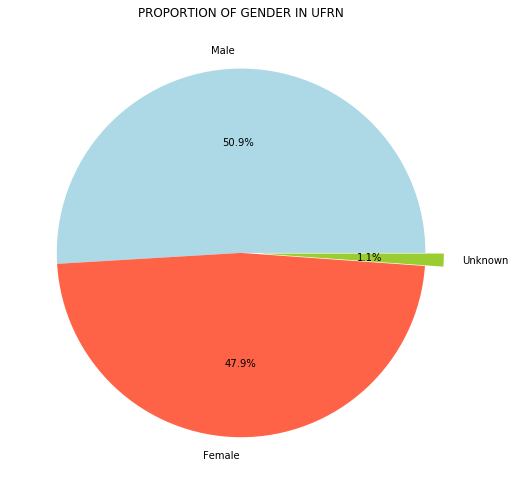

In [32]:

plt.figure(1, figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

labels = 'Male', 'Female', 'Unknown'
sizes = [data['GENDER'].value_counts()['male'], 
         data['GENDER'].value_counts()['female'], 
         len(data['GENDER']) - (data['GENDER'].value_counts()['male'] + 
                                data['GENDER'].value_counts()['female'])]

colors = ['lightblue', 'tomato', 'yellowgreen']
explode = (0, 0, 0.1)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=0)

ax.set_title('PROPORTION OF GENDER IN UFRN')

plt.show()

### 6.2 Gender by function

We can analyze the gender distribution on a closer manner and plot the number of each gender for each function. The bar plot below shows this for the 10 functions with most employees, in general (both genders). It's possible to see that for some function there is a lot of difference in the number of each gender.

Some functions has a historical culture that leads to a majority of one specific gender. This is the case of vigilant (vigilante), where we have 128 males and 0 female, it's also the case of nursing assistant (auxiliar de enfermagem), where we have 184 females and only 42 males.

But there is no historical culture that explains why we have so many professors male then female. And this could show an important inequality, because it's one of the most (if it's not the most) important function on a college.

In [33]:
# get the list of the 10 functions with most employees
functions = data['FUNCTION'].value_counts().keys()[:10].tolist()
# filter the dataset to get only the male employees
male_data = data[ data['GENDER'] == 'male' ]
# filter the dataset to get only the female employees
female_data = data[ data['GENDER'] =='female' ]

# get the number of male employees for the 10 funcntios with most employee (in general)
male_count = male_data['FUNCTION'].value_counts()[functions]
# get the number of female employees for the 10 funcntios with most employee (in general)
female_count = female_data['FUNCTION'].value_counts()[functions]

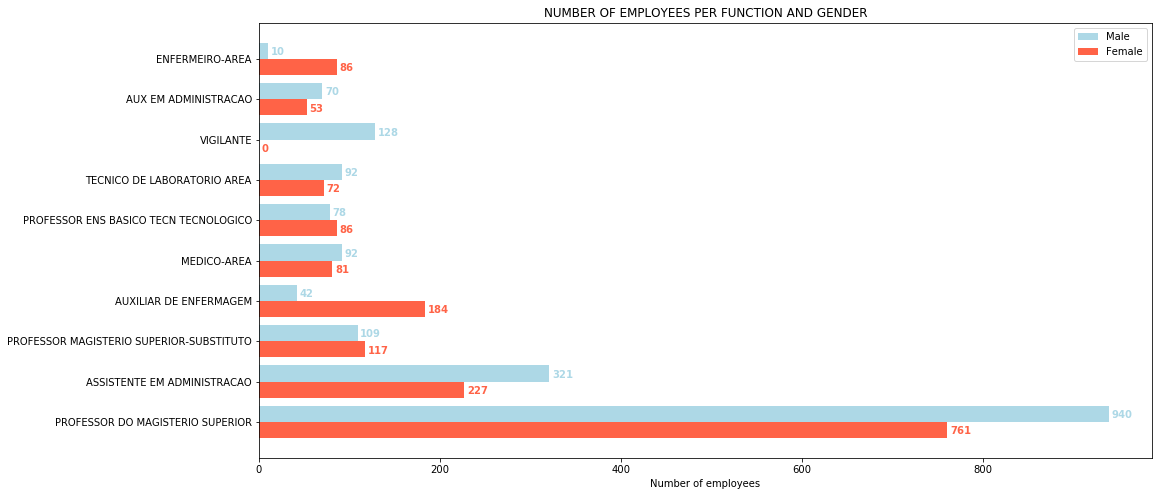

In [34]:
# Setting the positions and width for the bars
pos = list(range(len(functions)))
height = 0.4

# Plotting the bars
fig, ax = plt.subplots(figsize=(16,8))

ax.barh([p + height for p in pos], male_count, height, color='lightblue')
for i, v in enumerate(male_count):
    if not np.isnan(v):
        ax.text(v + 3, i + .3, str(int(v)), color='lightblue', fontweight='bold')
    else:
        ax.text(3, i + .3, '0', color='lightblue', fontweight='bold')

ax.barh(pos, female_count, height, color='tomato')
for i, v in enumerate(female_count):
    if not np.isnan(v):
        ax.text(v + 3, i - 0.1, str(int(v)), color='tomato', fontweight='bold')
    else:
        ax.text(3, i - 0.1, '0', color='tomato', fontweight='bold')


ax.set_yticks([p + height/2 for p in pos])
ax.set_yticklabels(functions)
ax.set_xlabel('Number of employees')
ax.set_title('NUMBER OF EMPLOYEES PER FUNCTION AND GENDER')

plt.legend(['Male', 'Female'], loc='upper right')

plt.show()

### 6.3 Mean salary by gender

In the column plot bellow, we show that the mean salary of females is 2,39% bigger than the mean salary of males. This difference isn't so representative, but shows a good equity in the salaries.

We also plot 3 pie charts, indicating the number of each gender for 3 cases: 

1. The 10 highest salaries; 
2. The 100 highest salaries; and 
3. The 100 lowest salaries. 

In the first case it's possible to observ a good equity, with a small advantage to male, consedering the small number of employees. But in the other 2 cases, we observe a remarkable difference, where males has more higher and also the lower salaries.

In [35]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.95*height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontweight='bold')

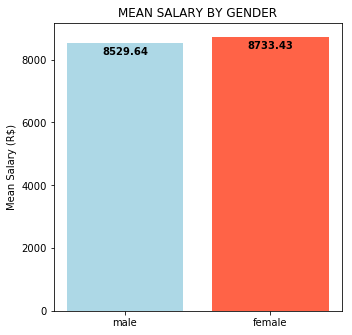

In [36]:
# make a square figure and axes
plt.figure(1, figsize=(10,10))
ax = plt.axes([0.1, 0.1, 0.4, 0.4])

gender_mean_salary = data.pivot_table(index='GENDER', values='MEAN_SALARY', aggfunc=np.mean)

bar_heights = [ gender_mean_salary.loc['male','MEAN_SALARY'],
                gender_mean_salary.loc['female','MEAN_SALARY']]

bar_positions = arange(2)

rect = ax.bar([1,2], bar_heights, color=['lightblue', 'tomato'], tick_label = ['male','female'])

ax.set_ylabel('Mean Salary (R$)')
ax.set_title('MEAN SALARY BY GENDER')
autolabel(rect)

plt.show()

In [37]:
print('Difference, in %%, of female salary over male salary: %.2f %%' % 
      ((bar_heights[1]/bar_heights[0] - 1)*100))

Difference, in %, of female salary over male salary: 2.39 %


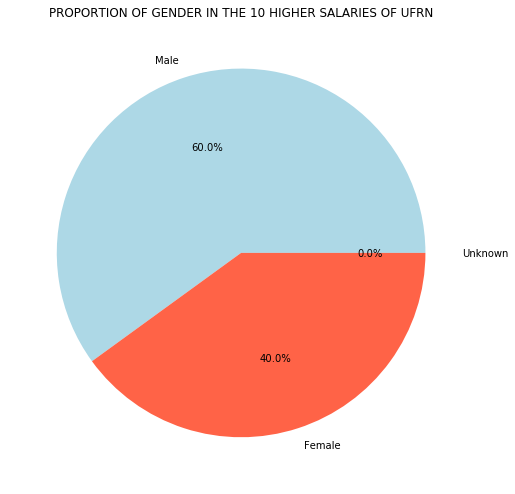

In [38]:
# 10+ salários homem x mulher - pizza

higher_salary = data.sort_values(by='MEAN_SALARY', ascending=False)[:10]
higher_salary['GENDER'].value_counts()

# make a square figure and axes
plt.figure(1, figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

labels = 'Male', 'Female', 'Unknown'
sizes = [higher_salary['GENDER'].value_counts()['male'], 
         higher_salary['GENDER'].value_counts()['female'], 
         len(higher_salary['GENDER']) - (higher_salary['GENDER'].value_counts()['male'] + 
                                         higher_salary['GENDER'].value_counts()['female'])]

colors = ['lightblue', 'tomato', 'yellowgreen']
explode = (0, 0, 0.1)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=0)
 
ax.set_title('PROPORTION OF GENDER IN THE 10 HIGHER SALARIES OF UFRN')
    
#plt.axis('equal')
plt.show()

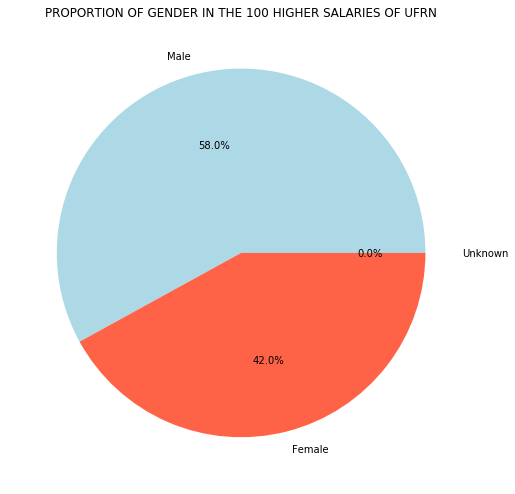

In [39]:
# 100+ salários homem x mulher - pizza

higher_salary = data.sort_values(by='MEAN_SALARY', ascending=False)[:100]
higher_salary['GENDER'].value_counts()

# make a square figure and axes
plt.figure(1, figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

labels = 'Male', 'Female', 'Unknown'
sizes = [higher_salary['GENDER'].value_counts()['male'], 
         higher_salary['GENDER'].value_counts()['female'], 
         len(higher_salary['GENDER']) - (higher_salary['GENDER'].value_counts()['male'] + 
                                         higher_salary['GENDER'].value_counts()['female'])]

colors = ['lightblue', 'tomato', 'yellowgreen']
explode = (0, 0, 0.1)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=0)
 
ax.set_title('PROPORTION OF GENDER IN THE 100 HIGHER SALARIES OF UFRN')
    
#plt.axis('equal')
plt.show()

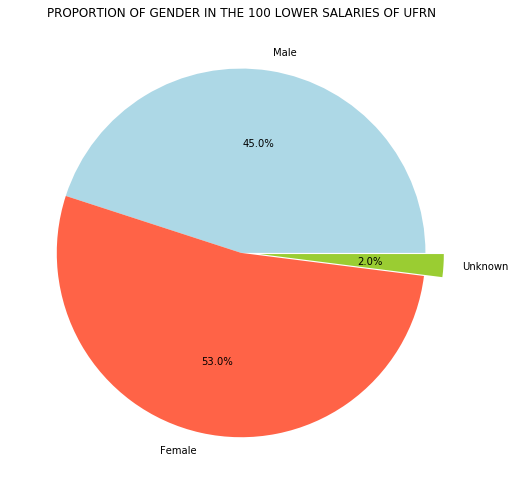

In [40]:
# 100- salários homem x mulher - pizza

lower_salary = data.sort_values(by='MEAN_SALARY', ascending=False)[-100:]
lower_salary['GENDER'].value_counts()

# make a square figure and axes
plt.figure(1, figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

labels = 'Male', 'Female', 'Unknown'
sizes = [lower_salary['GENDER'].value_counts()['male'], 
         lower_salary['GENDER'].value_counts()['female'], 
         len(lower_salary['GENDER']) - (lower_salary['GENDER'].value_counts()['male'] + 
                                        lower_salary['GENDER'].value_counts()['female'])]

colors = ['lightblue', 'tomato', 'yellowgreen']
explode = (0, 0, 0.1)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=0)
 
ax.set_title('PROPORTION OF GENDER IN THE 100 LOWER SALARIES OF UFRN')
    
#plt.axis('equal')
plt.show()

### 6.4 Mean salary by gender and function

We can explode the analyze of the salaries taking into consideration the functions and the gender. The bar plot bellow shows the mean salary for each gender of the 10 most popular functions of the UFRN. In general, it's possible to see a good equity in the salaries over each function.

In [48]:
male_data = data[ data['GENDER'] == 'male' ]
male_salary_by_function = male_data.pivot_table(index='FUNCTION', 
                                                values='MEAN_SALARY', 
                                                aggfunc = np.mean).loc[functions]

female_data = data[ data['GENDER'] == 'female' ]
female_salary_by_function = female_data.pivot_table(index='FUNCTION', 
                                                values='MEAN_SALARY', 
                                                aggfunc = np.mean).loc[functions]

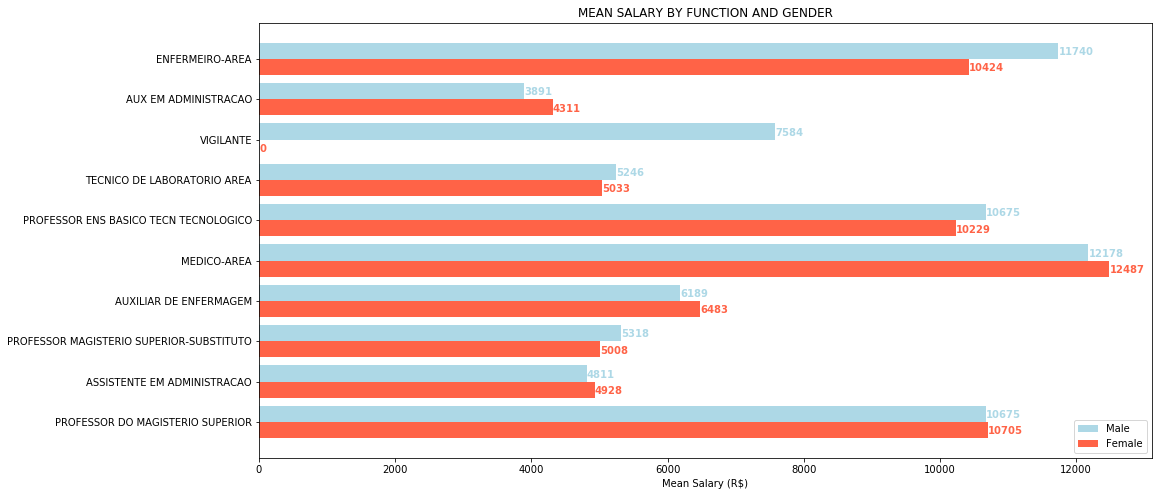

In [49]:
# Setting the positions and width for the bars
pos = list(range(len(functions)))
height = 0.4

# Plotting the bars
fig, ax = plt.subplots(figsize=(16,8))

ax.barh([p + height for p in pos], male_salary_by_function['MEAN_SALARY'], height, color='lightblue')
for i, v in enumerate(male_salary_by_function['MEAN_SALARY']):
    if not np.isnan(v):
        ax.text(v + 3, i + .3, str(int(v)), color='lightblue', fontweight='bold')
    else:
        ax.text(3, i + .3, '0', color='lightblue', fontweight='bold')

ax.barh(pos, female_salary_by_function['MEAN_SALARY'], height, color='tomato')
for i, v in enumerate(female_salary_by_function['MEAN_SALARY']):
    if not np.isnan(v):
        ax.text(v + 3, i - 0.1, str(int(v)), color='tomato', fontweight='bold')
    else:
        ax.text(3, i - 0.1, '0', color='tomato', fontweight='bold')

ax.set_yticks([p + height/2 for p in pos])
ax.set_yticklabels(functions)
ax.set_xlabel('Mean Salary (R$)')
ax.set_title('MEAN SALARY BY FUNCTION AND GENDER')

plt.legend(['Male', 'Female'], loc='lower right')

plt.show()

### 6.5 Correlation between service time and salary

One intesresting analyze is to verify the correlation between the service time and the salary. Bellow we show the scatter plot of the 10 most popular functions of UFRN. We can see that for some functions we have a high correlation between those two variables, e.g. assistente em administração, others we have a low correlation, e.g. enfermeiro area, and we have some that shows no correlation at all, like medico-area. This could be explain due to the different working hours possibility and some personal aids.

In [42]:
# cleaning the dataset in order to rest only numbers that can be interpreted by the scatter plot
scatter_data = data.dropna(axis=0, how='any', subset=['SERVICE_TIME','MEAN_SALARY'])

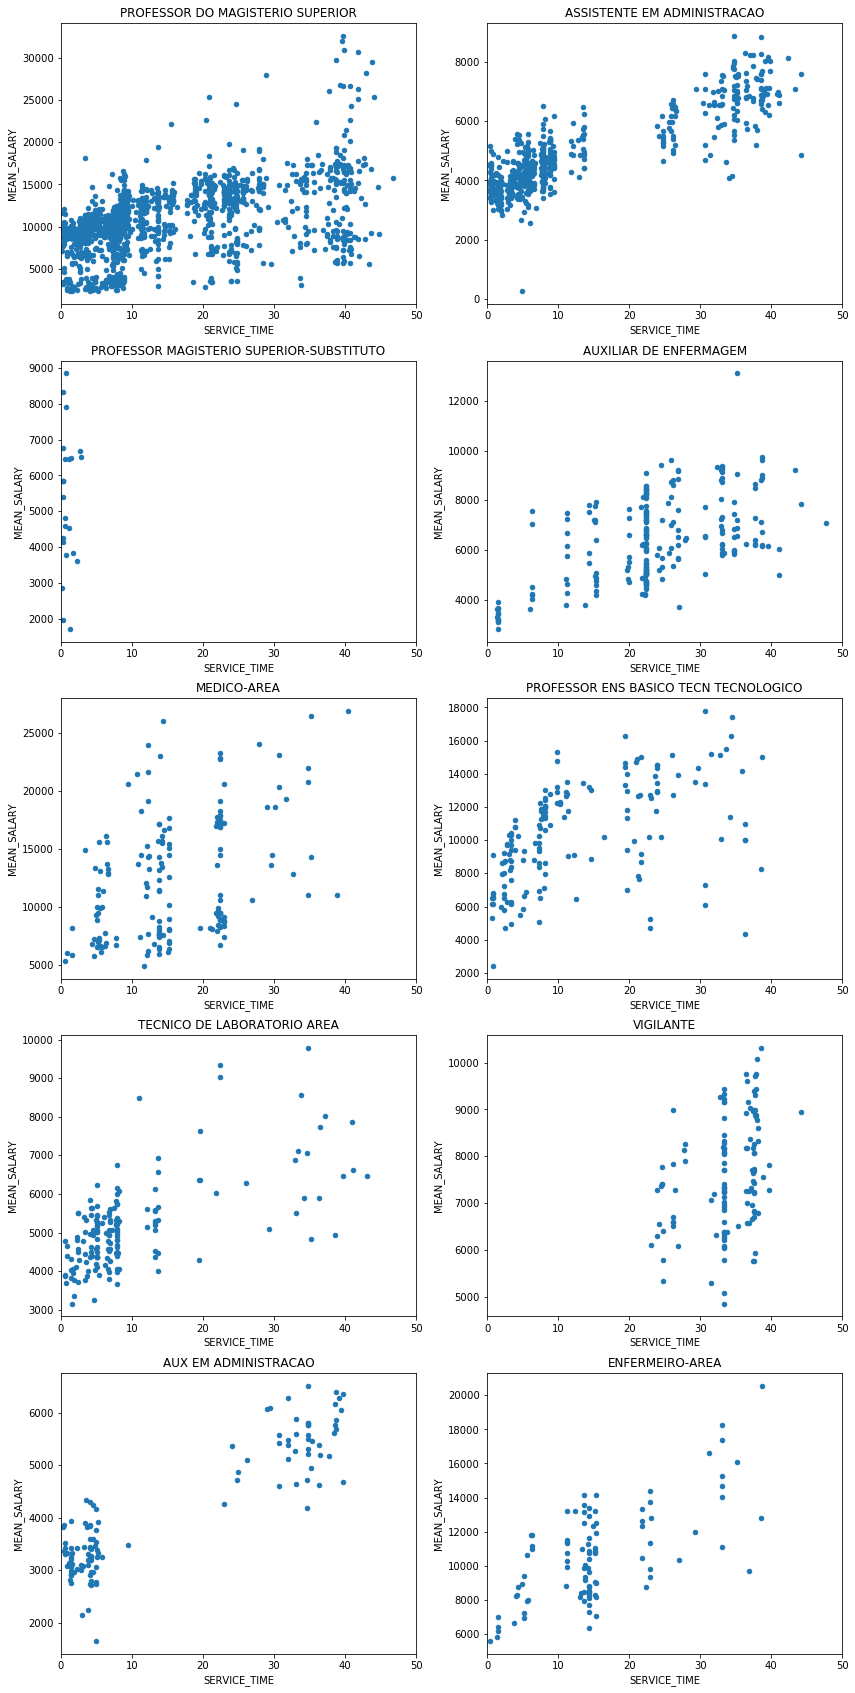

In [43]:
%matplotlib inline

fig, axes = plt.subplots(nrows=int(len(functions)/2), ncols=2, figsize=(14,30))


for i in range(len(functions)):
    ax = (scatter_data[ scatter_data['FUNCTION'] == functions[i] ].
              plot(kind='scatter', x='SERVICE_TIME', y='MEAN_SALARY',
                   title=functions[i], ax=axes[i//2, i%2]))
    ax.set_xlim(0, 50)

## 7. Conclusion

That is a lot more analysis we could make only with those informations collected and a infinite number if we consider the possibility to collect more data on the Internet. Therefore, we conclude that the Web Scraping technique, combined with the tools to analyze the data available, create a infinite number of analysis to be made. Knowing the fact that we already have a lot of data available on the Internet, it's just becomes a matter of decide what analysis could bring a good and relevant insight to help the society to evolve.